In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CSVを読み込む
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

# データの統合
dataset = pd.concat([train, test], ignore_index = True)

# 提出用に
PassengerId = test['PassengerId']

In [3]:
# 客室階層による生存率比較
dataset['Cabin'] = dataset['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
dataset['Deck']= dataset['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

# チケットの文字数による生存率比較
Ticket_Count = dict(dataset['Ticket'].value_counts()) # チケットの文字数でグループ分け
dataset['TicketGroup'] = dataset['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け

# チケットの文字数での生存率が高いグループと低いグループの２つに分ける。
# 高ければ２，低ければ１を代入
def Ticket_Label(s):
    if (s >= 2) & (s <= 4): # 文字数での生存率が高いグループ
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1): # 文字数での生存率が低いグループ
        return 1
    elif (s > 8):
        return 0

dataset['TicketGroup'] = dataset['TicketGroup'].apply(Ticket_Label)

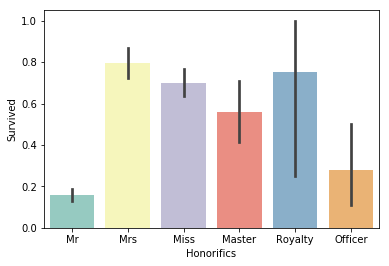

In [4]:
# 'Honorifics'(敬称)による特徴別に分ける
dataset['Honorifics'] = dataset['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #敬称(','と'.'の間の単語)を抽出

# 敬称をグループ分け
# 例：'Capt', 'Col', 'Major', 'Dr', 'Rev'は'Officer'とする
Honorifics_Dict = {}
Honorifics_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Honorifics_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Honorifics_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Honorifics_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Honorifics_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Honorifics_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
dataset['Honorifics'] = dataset['Honorifics'].map(Honorifics_Dict)
sns.barplot(x="Honorifics", y="Survived", data=dataset, palette='Set3')

"""敬称一覧
Mr：男 , Master：男の子, Jonkheer：オランダ貴族(男),
Mlle：マドモワゼル (フランス未婚女性), Miss：未婚女性、女の子, Mme：マダム(フランス既婚女性), Ms：女性(未婚・既婚問わず), Mrs：既婚女性, 
Don：スペイン貴族(男), Sir：イギリス貴族(男), the Countess：伯爵夫人, Dona：スペイン貴族夫人(既婚女性), Lady：イギリス貴族夫人(既婚女性),
Capt：船長, Col：大佐, Major：軍人, Dr：医者, Rev：聖職者や牧師
"""

In [5]:
## 年齢の欠損値を予測して代入
# 年齢予測のために使う項目を抽出し、ダミー変数を作成
age = dataset[['Age','Pclass','Sex','Honorifics']]
age_dummies = pd.get_dummies(age)
age_dummies.head(3)

,Age,Pclass,Sex_female,Sex_male,Honorifics_Master,Honorifics_Miss,Honorifics_Mr,Honorifics_Mrs,Honorifics_Officer,Honorifics_Royalty
0,22.0,3,0,1,0,0,1,0,0,0
1,38.0,1,1,0,0,0,0,1,0,0
2,26.0,3,1,0,0,1,0,0,0,0


In [6]:

# ageがわかるものと欠損しているものに分ける
known_age = age_dummies[age_dummies.Age.notnull()].as_matrix()
null_age = age_dummies[age_dummies.Age.isnull()].as_matrix()

# 得微量と正解データに分ける
age_X = known_age[:, 1:]
age_y = known_age[:, 0]

# 年齢予測モデルを作成し、予測した値を代入
rf = RandomForestRegressor()
rf.fit(age_X, age_y)
pred_Age = rf.predict(null_age[:, 1:])
dataset.loc[(dataset.Age.isnull()),'Age'] = pred_Age

In [7]:
# 'Embarked'(出港地)が欠損しているデータを表示
dataset[dataset['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,TicketGroup,Honorifics
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,B,2,Miss
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,B,2,Mrs


In [8]:
# 'Pclass'(チケットクラス)が１の、'Embarked'(出港地)ごとの'Fare'(料金)中央値を表示
C = dataset[(dataset['Embarked']=='C') & (dataset['Pclass'] == 1)]['Fare'].median()
print("Cの中央値", C)
S = dataset[(dataset['Embarked']=='S') & (dataset['Pclass'] == 1)]['Fare'].median()
print("Sの中央値", S)
Q = dataset[(dataset['Embarked']=='Q') & (dataset['Pclass'] == 1)]['Fare'].median()
print("Qの中央値", Q)

# 'Embarked'の欠損値にCを代入
dataset['Embarked'] = dataset['Embarked'].fillna('C')

Cの中央値 76.7292
Sの中央値 52.0
Qの中央値 90.0


In [9]:
# 'Fare'(料金)が欠損しているデータを表示
dataset[dataset['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,TicketGroup,Honorifics
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,U,1,Mr


In [10]:
# 'Pclass'(チケットクラス)が3で、'Embarked'(出港地)が'S'の中央値を代入
fare_median=dataset[(dataset['Embarked'] == "S") & (dataset['Pclass'] == 3)].Fare.median()
dataset['Fare']=dataset['Fare'].fillna(fare_median)

In [11]:
# 全体の欠損データの個数を確認
dataset_null = dataset.fillna(np.nan)
dataset_null.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Deck             0
TicketGroup      0
Honorifics       0
dtype: int64

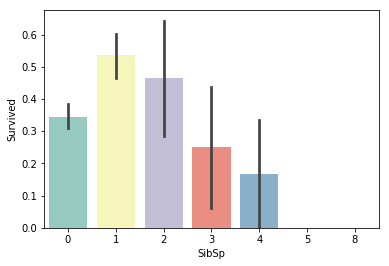

In [12]:
# 同乗している兄弟/配偶者の数による生存率比較
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')

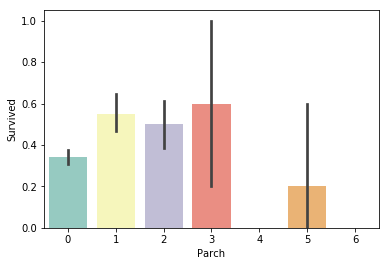

In [13]:
# 同乗している親/子供の数による生存率比較
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')

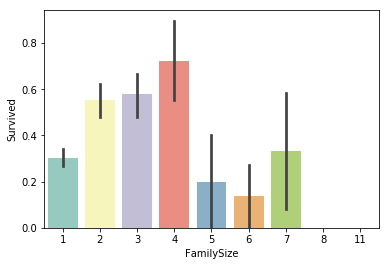

In [14]:
# 同乗している家族の数
dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=dataset, palette='Set3')

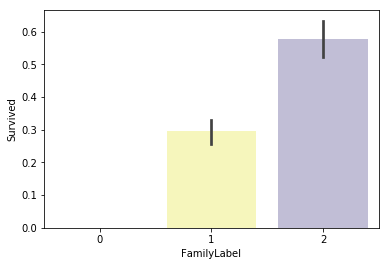

In [15]:
# 家族数による生存率でグループ分け
def Family_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
dataset['FamilyLabel']=dataset['FamilySize'].apply(Family_label)
sns.barplot(x="FamilyLabel", y="Survived", data=dataset, palette='Set3')

In [16]:
# 苗字による特徴を調べる
dataset['Surname'] = dataset['Name'].apply(lambda x:x.split(',')[0].strip()) # 苗字(名前の","の前の単語）を抽出
Surname_Count = dict(dataset['Surname'].value_counts()) # 苗字の個数を数える
dataset['Surname_Count'] = dataset['Surname'].apply(lambda x:Surname_Count[x]) # 苗字の個数を代入

# 苗字にダブりがある人を、女・子供のグループと、大人で男性のグループに分ける
Female_Child_Group=dataset.loc[(dataset['Surname_Count']>=2) & ((dataset['Age']<=12) | (dataset['Sex']=='female'))]
Male_Adult_Group=dataset.loc[(dataset['Surname_Count']>=2) & (dataset['Age']>12) & (dataset['Sex']=='male')]

# 女・子供グループにおける苗字ごとの生存率平均の個数を比較
Female_Child_mean = Female_Child_Group.groupby('Surname')['Survived'].mean() # 苗字ごとの生存率平均
Female_Child_mean_count = pd.DataFrame(Female_Child_mean.value_counts()) # 苗字ごとの生存率平均の数
Female_Child_mean_count.columns=['GroupCount']
Female_Child_mean_count

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


In [17]:
# 男（大人）グループにおける苗字ごとの生存率平均の個数を比較
Male_Adult_mean = Male_Adult_Group.groupby('Surname')['Survived'].mean() # 苗字ごとの生存率平均
Male_Adult_mean_count = pd.DataFrame(Male_Adult_mean.value_counts()) # 苗字ごとの生存率平均の数
Male_Adult_mean_count.columns=['GroupCount']
Male_Adult_mean_count

# どちらのグループも大抵０か１となり、グループで差が大きく存在。
# 女子供は生存率が高く、男（大人）は低い

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [18]:
# 各グループの例外を処理
# 各グループの例外となる苗字を抽出
# Dead_List：女・子供グループで全員死亡した苗字
# Survived_List：男（大人）グループで全員死亡した苗字
Dead_List = set(Female_Child_mean[Female_Child_mean.apply(lambda x:x==0)].index)
print("Dead_List", Dead_List, sep="\n")
Survived_List = set(Male_Adult_mean[Male_Adult_mean.apply(lambda x:x==1)].index)
print("Survived_List", Survived_List, sep="\n")

Dead_List
{'Danbom', 'Turpin', 'Zabour', 'Bourke', 'Olsson', 'Goodwin', 'Cacic', 'Robins', 'Canavan', 'Lobb', 'Palsson', 'Ilmakangas', 'Oreskovic', 'Lefebre', 'Sage', 'Johnston', 'Arnold-Franchi', 'Skoog', 'Attalah', 'Lahtinen', 'Jussila', 'Ford', 'Vander Planke', 'Rosblom', 'Boulos', 'Rice', 'Caram', 'Strom', 'Panula', 'Barbara', 'Van Impe'}
Survived_List
{'Chambers', 'Beane', 'Jonsson', 'Cardeza', 'Dick', 'Bradley', 'Duff Gordon', 'Greenfield', 'Daly', 'Nakid', 'Taylor', 'Frolicher-Stehli', 'Beckwith', 'Kimball', 'Jussila', 'Frauenthal', 'Harder', 'Bishop', 'Goldenberg', 'McCoy'}


In [19]:
# テストデータを書き換える
# データをtrainとtestに分解 
train = dataset.loc[dataset['Survived'].notnull()]
test = dataset.loc[dataset['Survived'].isnull()]

# 女・子供グループで全員死亡した苗字の人→６０歳の男性、敬称はMrに。
# 男（大人）グループで全員生存した苗字の人→５才の女性、敬称はMissに。
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

# 再びデータを結合
dataset = pd.concat([train, test])

In [21]:
# 使用する変数を抽出
dataset6 = dataset[['Survived','Pclass','Sex','Age','Fare','Embarked','Honorifics','FamilyLabel','Deck','TicketGroup']]
# ダミー変数を作成
dataset_dummies = pd.get_dummies(dataset6)
dataset_dummies.head(3)

,Survived,Pclass,Age,Fare,FamilyLabel,TicketGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Honorifics_Royalty,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,3,22.0,7.2500,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,2,2,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# データをtrainとtestに分解 
#（ 'Survived'が存在するのがtrain, しないのがtest ）
train_set = dataset_dummies[dataset_dummies['Survived'].notnull()]
test_set = dataset_dummies[dataset_dummies['Survived'].isnull()]
del test_set["Survived"]

# trainデータを変数と正解に分離
X = train_set.as_matrix()[:, 1:] # Pclass以降の変数
y = train_set.as_matrix()[:, 0] # 正解データ


In [29]:
# 予測モデルの作成
pipe = Pipeline([('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20, 30, 1)), 
              'classify__max_depth':list(range(3, 10, 1))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='accuracy', cv=10)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

# train {'classify__max_depth': 5, 'classify__n_estimators': 28} 0.8451178451178452
# test 0.81818

{'classify__max_depth': 5, 'classify__n_estimators': 28} 0.8451178451178452


In [30]:
# testデータの予測
predictions = gsearch.predict(test_set)

# Kaggle提出用csvファイルの作成
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission6.csv", index=False)

In [31]:
pipe = Pipeline([('select',SelectKBest(k=20)),  # 予測に役立つ得微量を２０個使ってモデルを作成
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20, 30, 1)), 
              'classify__max_depth':list(range(3, 10, 1))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='accuracy', cv=10)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 26} 0.8451178451178452


In [32]:
# 与えられたmax_depthとn_estimatorsを利用して、得微量を２０に絞って再度予測モデルを作成し、予測
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x000002926E358BF8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...imators=26, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [33]:
cv_score = model_selection.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8451402 | Std - 0.03276752 


In [34]:
predictions = pipeline.predict(test_set)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission7.csv", index=False)
# 0.83732